จากใน ep เรื่อง [AI จำแนกรูปภาพ Image Classification หมา แมว 37 สายพันธุ์](https://www.bualabs.com/archives/469/how-to-deep-learning-pets-cats-dogs-image-classification-with-fastai-v1-ep-1/) ใน ep นี้เราจะมาเรียนรู้เทคนิดเพิ่มเติมในเรื่อง Data Augmentation คือ Mixup และ Loss Function คือ Label Smoothing

# 0. Magic Commands

ให้ใส่ไว้บนสุดทุก Notebook เป็นการสั่งให้ Notebook ก่อนรัน ให้รีโหลด Library ภายนอกที่เรา import ไว้ใหม่โดยอัตโนมัติ 

และให้พล็อตกราฟ matplotlib ใน Output ของ cell แบบ code ได้เลย

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# 1. Import Library

Import Library ที่เราจะใช้ ในที่นี้คือ fastai version 1, fastai มี package ย่อย ๆ หลายอัน แต่ที่เราจะใช้ใน Notebook นี้คือ vision สำหรับงานเกี่ยวกับ Computer Vision และ metrics สำหรับวิเคราะห์ประสิทธิภาพของ Model

การ import * หมายความว่า import ทุกอย่างที่อยู่ใน package ทำให้เราไม่ได้ต้องมา import ทีละ class การ import แบบนี้ เหมาะสำหรับการทดลองอะไรใหม่ ๆ เพราะเราไม่ต้องย้อนมาแก้ import ทุกครั้งเมื่อต้องการใช้ class ใหม่ ๆ แต่ไม่แนะนำสำหรับใช้งานจริงบน Production

In [0]:
 !curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
from fastai import *
from fastai.vision import *
from fastai.metrics import accuracy

In [0]:
! nvidia-smi

Sat Dec 14 10:08:02 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# 2. ข้อมูล

ในเคสนี้ เราจะใช้ข้อมูลจาก Oxford-IIIT Pet Dataset by O. M. Parkhi et al., 2012 ซึ่งเป็นชุดข้อมูลรูปภาพหมา 25 พันธุ์ และรูปแมว 12 พันธุ์ รวมเป็น 37 หมวดหมู่ 

อ้างอิงจากใน paper ในปี 2012 โมเดลที่ดีที่สุด สามารถทำนายพันธุ์สัตว์ ได้ถูกต้อง 59.21% โดยโมเดลนั้น ออกแบบมาเฉพาะทาง สำหรับแยกรูปสัตว์ หัวสัตว์ ตัวสัตว์ โดยเฉพาะ (สมัยนันยังไม่ใช่ Deep Learning)

เรามาดูกันว่าเราจะใช้ Deep Learning ทำนายพันธุ์หมาแมวจากรูป ได้ถูกต้องแม่นยำกว่าหรือไม่ 

URL ของ Dataset ที่เราจะ Download มาใช้

In [0]:
URLs.PETS

'https://s3.amazonaws.com/fast-ai-imageclas/oxford-iiit-pet'

ฟังก์ชัน untar_data จะดาวน์โหลด [Dataset](https://www.bualabs.com/archives/1994/dataset-dataloader-feed-data-x-y-batch-to-neural-network-refactor-training-loop-neural-network-ep-5/) และ Extract ไฟล์ให้เราอัตโนมัติ ไว้ใน $HOME/.fastai/data เวลาเรารันใหม่ จะได้ไม่ต้อง Download ใหม่ทุกครั้ง เมื่อแตกไฟล์ออกมาแล้ว ก็ ls ดูว่ามีโฟล์เดอร์อะไรอยู่บ้าง

In [0]:
path = untar_data(URLs.PETS)
path.ls()

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations')]

ที่เราสนใจตอนนี้มี 2 path คือ images ที่เก็บรูป และ annotations ที่เก็บข้อมูลประกอบ

In [0]:
path_annotations = path/'annotations'
path_images = path/'images'

ลอง ls ดูใน path_annotations จะเห็นว่ามีไฟล์ข้อมูลประกอบรูปหลายไฟล์ด้วยกัน

In [0]:
path_annotations.ls()

[PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations/trainval.txt'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations/._trimaps'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations/list.txt'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations/xmls'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations/README'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations/trimaps'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations/test.txt')]

## Label ชื่อพันธุ์ อยู่ในชื่อไฟล์ ##

ดึงรายชื่อไฟล์จาก path_images และแสดงรายการ 10 ไฟล์แรก

สังเกตว่าทั้งหมดเป็นรูปนามสกุล jpg อยู่ใน path ด้วยกัน ชื่อไฟล์เป็นชื่อพันธุ์ ตามด้วย _ ตามด้วย เลข Running ตามด้วย .jpg

In [0]:
filenames = get_image_files(path_images)
filenames[:10]

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images/British_Shorthair_38.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/keeshond_23.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/leonberger_62.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/chihuahua_151.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/samoyed_85.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Russian_Blue_100.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Ragdoll_100.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/chihuahua_67.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/newfoundland_31.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/havanese_40.jpg')]

# 3. เตรียมข้อมูล

ก่อนนำข้อมูลใด ๆ มาเทรน Model เราต้องมีการเตรียมข้อมูล กำหนด [Data Pipeline](https://www.bualabs.com/archives/2693/data-block-api-data-pipeline-machine-learning-supervised-learning-preprocessing-ep-5/) ให้อยู่ในรูปแบบที่เหมาะสมเสียก่อน

[batchsize](https://www.bualabs.com/archives/729/what-is-batch-size-in-deep-neural-networks-how-to-adjust-machine-learning-model-accuracy-deep-learning-hyperparameter-tuning-ep-2/) หมายถึงให้ป้อนข้อมูลให้ Model ทีละ 64 records, [GPU](https://www.bualabs.com/archives/1426/why-gpu-require-train-deep-learning-compare-cpu-vs-gpu-deep-neural-network-hardware-ep-2/) สามารถทำงานได้รวดเร็ว เพราะ ข้อได้เปรียบของ GPU คือมี Core จำนวนมาก การป้อนข้อมูลรูปแบบคล้าย ๆ กันให้ GPU ไปทำงานพร้อม ๆ กันหลาย ๆ Record ในทีเดียว จะเร็วกว่าใช้ CPU ทำงานไปทีละ Record มากกว่า 100 เท่า

random seed หมายถึง กำหนดค่าเริ่มต้นของการสุ่ม เพื่อให้รันทุกครั้งแล้วได้เหมือนเดิมทุกครั้ง จะได้สะดวกในการเปรียบเทียบ แต่ไม่แนะนำสำหรับงาน Production

regex_pattern หมายถึง เราจะใช้ Regular Expression ตัดชื่อไฟล์ดูจากท้ายสุด ($), ดู .jpg, ดูตัวเลข (d+), ดู _ แล้วเอาตัวอักษรทั้งหมด ก่อนถึง / มาเป็น label ชื่อพันธุ์

In [0]:
batchsize = 64
np.random.seed(42)
regex_pattern = r'/([^/]+)_\d+.jpg$'

from_name_re คือ Factory Method กำหนด [Data Pipeline](https://www.bualabs.com/archives/2693/data-block-api-data-pipeline-machine-learning-supervised-learning-preprocessing-ep-5/) ในการสร้าง DataBunch โดยใช้ regex_pattern (Regular Expression) จาก ชื่อไฟล์มาเป็น labe

* ds_tfms คือ Dataset Transforms การแปลงข้อมูลรูปภาพ เช่น ย่อขยาย crop ปรับสี ความสว่าง etc. จะพูดถึงในเรื่อง [Data Augmentation](https://www.bualabs.com/archives/1170/what-is-data-augmentation-benefits-data-augmentaion-deep-learning-training-model-deep-neural-network-regularization-ep-1/) ที่ไว้เราจะอธิบายต่อไป แต่ตอนนี้เพื่อให้เปรียบเทียบได้ชัด เราจะไม่ทำ Data Augmentation เลย
* size คือ resize รูปทั้งหมดให้เป็น 224 x 224 pixels
* bs คือ batchsize
* [normalize](https://www.bualabs.com/archives/2100/what-is-normalization-feature-scaling-rescaling-normalization-standardization-feedforward-train-machine-learning-preprocessing-ep-2/) คือการแปลงข้อมูล ตาม imagenet_stats จากรูปสี จาก 0-255 x 3 channels RGB ให้มี Mean = 0 และ Standard Deviation = 1 ที่ไว้เราจะอธิบายต่อไป

*ที่ไม่ได้ใส่เป็น parameter ได้แก่ valid_pct คือ ค่า Percent สำหรับ แบ่ง [train/valid split](https://www.bualabs.com/archives/532/what-is-training-set-why-train-test-split-training-set-validation-set-test-set/) ซึ่งค่า Default คือ 20%*


In [0]:
tfms_none = [[], []]
databunch = ImageDataBunch.from_name_re(path_images, filenames, 
                                   regex_pattern, ds_tfms=tfms_none, 
                                   size=224, bs=batchsize).normalize(imagenet_stats)

เราจะได้ [DataBunch](https://www.bualabs.com/archives/2318/databunch-learner-refactor-neural-network-training-loop-neural-network-ep-9/) บรรจุ train Dataset จำนวน 5912 record และ validation Dataset จำนวน 1478 record หรือ 1478 / (1478+5912) = 20%

In [0]:
len(databunch.train_ds), len(databunch.valid_ds)

(5912, 1478)

## สำรวจข้อมูล ##

เรียกข้อมูลจาก [DataLoader](https://www.bualabs.com/archives/1994/dataset-dataloader-feed-data-x-y-batch-to-neural-network-refactor-training-loop-neural-network-ep-5/) ที่อยู่ใน DataBunch ลองดูข้อมูล Batch แรก ด้วย show_batch สั่งให้แสดง รูป พร้อม label ชื่อพันธุ์ไว้บนรูป แสดง 3 แถว (rows) ในกรอบขนาด 9 x 9 นิ้ว (figsize)

*เราสามารถรัน cell นี้หลายครั้ง เพื่อเรียกดู batch ต่อ ๆ ไป ได้เรื่อย ๆ เป็นการสำรวจข้อมูล*

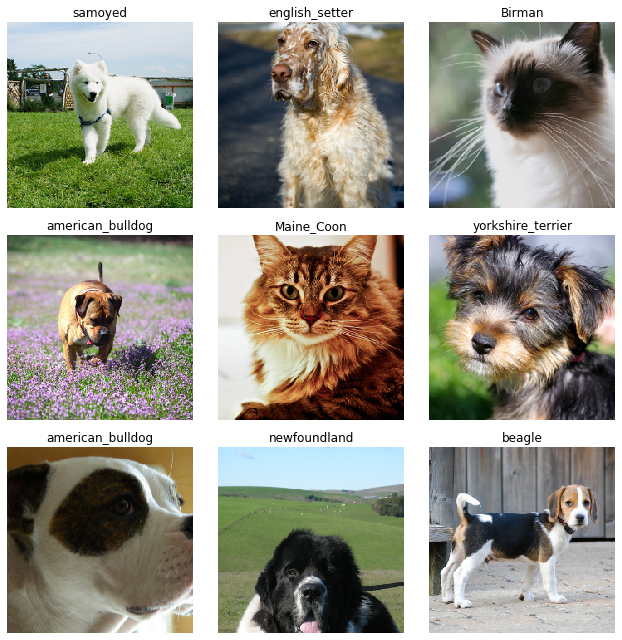

In [0]:
databunch.show_batch(rows=3, figsize=(9, 9))

ดู label พันธุ์หมาแมวทั้งหมด หรือ class ทั้งหมด ที่มีใน Dataset

In [0]:
print(databunch.classes)

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


c จำนวน label ที่จะนำไปใช้ใน model

In [0]:
print(databunch.c)

37


จำนวนพันธุ์ใน dataset

In [0]:
len(databunch.classes)

37

# 4. สร้างโมเดล + Mixup

สร้าง [CNN](https://www.bualabs.com/archives/2461/what-is-convolutional-neural-network-cnn-convnet-mnist-deep-learning-convnet-ep-1/) Learner ด้วยฟังก์ชัน cnn_learner ระบุ databunch ของข้อมูลที่จะใช้เทรน, [Model Architecture](https://www.bualabs.com/archives/2703/how-to-read-model-convolutional-neural-network-shape-activation-map-model-architecture-convnet-ep-7/), ต้องการ Transfer Learning หรือไม่, [metrics](https://www.bualabs.com/archives/1968/what-is-metrics-confusion-matrix-accuracy-precision-recall-f1-score-difference-metrics-ep-1/) การวัดผลในเคสนี้เราจะใช้ [Accuracy](https://www.bualabs.com/archives/2075/validation-metrics-neural-network-validation-set-train-machine-learning-neural-network-ep-8/)

* โดย default cnn_learner จะลบ layer สุดท้ายของ model ที่ดาวน์โหลดมาทิ้งไป และแทนที่ด้วย Layer ใหม่ ที่มี 37 Output ตรงกับ databunch.c ของเรา
* model จะถูก Save ไว้ที่ $HOME/.torch/models เมื่อรันอีกครั้งจะไม่ได้ต้องดาวน์โหลดใหม่
* mixup จะใช้ Data Augmentation แบบ Mixup 
* LabelSmoothingCrossEntropy ใช้ Cross Entropy Loss แบบ Label Smoothing

In [0]:
loss_func = LabelSmoothingCrossEntropy()
learner = cnn_learner(databunch, models.resnet34, loss_func=loss_func, metrics=accuracy).mixup().to_fp16()

# 5. เริ่มต้นเทรนโมเดล

ลอง fit ด้วย ค่า default จำนวน 6 epoch

* 1 [epoch](https://www.bualabs.com/archives/618/learning-rate-deep-learning-how-to-hyperparameter-tuning-ep-1/) คือ ใช้ป้อนข้อมูล หมด Dataset 1 รอบ
* fit_one_cycle คือ การเทรนแบบพิเศษ ที่ใช้ [Learning Rate ไม่คงที่](https://www.bualabs.com/archives/2452/schedule-hyperparameter-train-machine-learning-deep-neural-network-one-cycle-learning-rate-neural-network-ep-13/) ไว้เราจะอธิบายต่อไป

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.02E-03
Min loss divided by 10: 8.32E-03


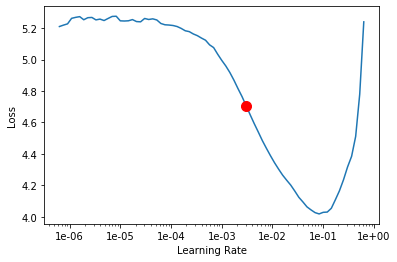

In [0]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [0]:
learner.fit_one_cycle(6, max_lr=3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.963802,1.123542,0.889716,00:55
1,2.262428,1.070243,0.895129,00:55
2,1.963332,0.998481,0.901894,00:55
3,1.805121,0.931815,0.923545,00:55
4,1.716672,0.912487,0.935047,00:55
5,1.675563,0.904485,0.938430,00:55


## สำเร็จแล้ว ##

เรา[เทรนด้วย GPU](https://www.bualabs.com/archives/1426/why-gpu-require-train-deep-learning-compare-cpu-vs-gpu-deep-neural-network-hardware-ep-2/) เพียงแค่เวลาไม่ถึง 6 นาที ไม่ได้ใช้ [Data Augmentation](https://www.bualabs.com/archives/1170/what-is-data-augmentation-benefits-data-augmentaion-deep-learning-training-model-deep-neural-network-regularization-ep-1/) อื่นเลย ใช้แต่ Mixup เราเทรน Model ได้ accuracy ประมาณ 0.94 หรือ ความแม่นยำประมาณ 94%

เปรียบเทียบกับ paper เมื่อปี 2012 ที่ได้ 59.21% หรือเปรียบเทียบกับมนุษย์ คงเป็นเรื่องยาก ถ้าให้เวลาเรา 3 นาที ดูรูปหมาแมว แล้วให้ทายว่าเป็นพันธุ์อะไร 1 ใน 37 สายพันธุ์ แต่ [Model Deep Learning](https://www.bualabs.com/archives/469/how-to-deep-learning-pets-cats-dogs-image-classification-with-fastai-v1-ep-1/) ของเรา นี้สามารถทายได้ถูกต้องถึง 94% โดยใช้เวลาในการเรียนรู้เพียงแค่ 6 นาทีเท่านั้น 

เรามา Save Model ที่เราเพิ่งเทรนไปเก็บไว้ก่อน

In [0]:
learner.save('01h-image-classification-pets-resnet34-1')

# 6. ดูสถิติของโมเดล

เรามาดูกราฟ Train Loss และ [Validation Loss](https://www.bualabs.com/archives/2075/validation-metrics-neural-network-validation-set-train-machine-learning-neural-network-ep-8/) ตามจำนวน Batch ข้อมูลที่เราป้อนให้โมเดล

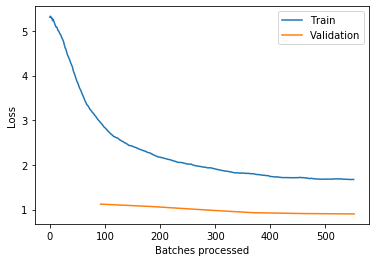

In [0]:
learner.recorder.plot_losses()

กราฟค่า Learning Rate ตามจำนวน Iteration ของการเทรน จะเห็นได้ว่า Learning Rate ไม่คงทีมีขึ้นมีลง เป็นความพิเศษของ [fit_one_cycle](https://www.bualabs.com/archives/2452/schedule-hyperparameter-train-machine-learning-deep-neural-network-one-cycle-learning-rate-neural-network-ep-13/) ที่ไว้เราจะอธิบายต่อไป

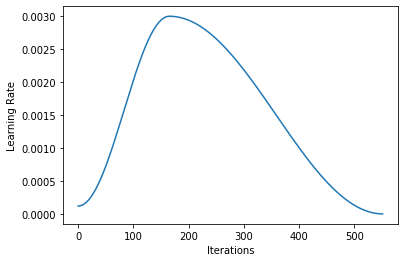

In [0]:
learner.recorder.plot_lr()

เรามาดูกราฟ accuracy ตามจำนวน Batch ข้อมูลที่เราป้อนให้โมเดล ไปสูงสุดประมาณ 94%

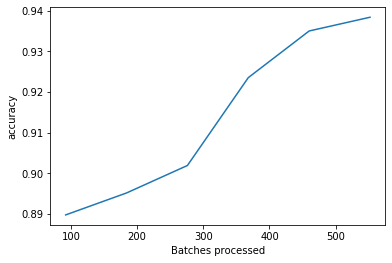

In [0]:
learner.recorder.plot_metrics()

โหลดโมเดลที่เรา Save ไว้ ขึ้นมาใหม่ เตรียมเทรนในขึ้นตอนถัดไป (ที่คอมเม้นท์ไว้ เพราะถ้าไม่ได้เปลี่ยนอะไรก็จะได้ไม่ต้องรัน)

In [0]:
# learner.load('01h-image-classification-pets-resnet34-1');

# 7. ดูผลลัพธ์

ถ้าเราดูแค่ accuracy อย่างเดียว เราอาจจะไม่เห็นภาพว่า Model ทำงานได้ผลลัพธ์อย่างไร 

เราจะสร้าง ClassificationInterpretation เป็น class ที่มาช่วยตีความผลลัพธ์ ให้เราดูเข้าใจง่ายขึ้น

In [0]:
interpretation = ClassificationInterpretation.from_learner(learner.to_fp32())

สั่งให้ plot_top_losses largest = True คือ แสดง record ที่ ค่า loss น้อยที่สุด หรือพูดง่าย ๆ ว่าแสดงรายการที่โมเดลทายถูกด้วยความมั่นใจ 9 อันดับแรก

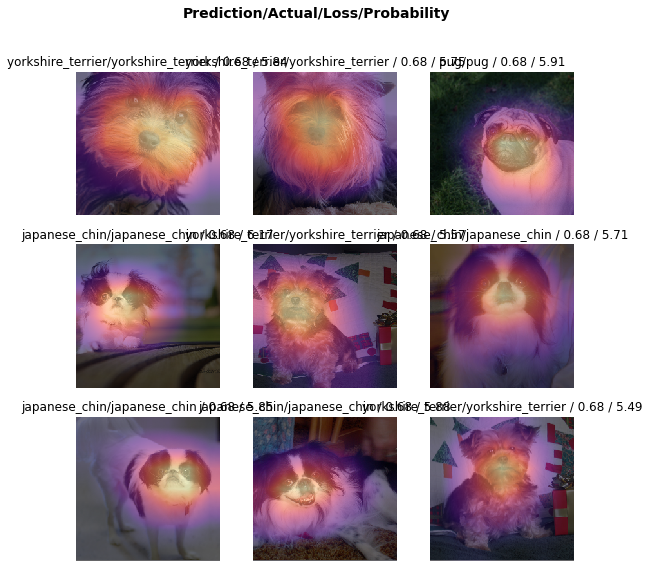

In [0]:
interpretation.plot_top_losses(9, figsize=(9,9), heatmap=True, largest=False)

สั่งให้ plot_top_losses คือ แสดง record ที่ ค่า [loss](https://www.bualabs.com/archives/2673/what-is-loss-function-cost-function-error-function-loss-function-how-cost-function-work-machine-learning-ep-1/) มากที่สุด หรือพูดง่าย ๆ ว่าแสดงรายการที่โมเดลทายผิด 9 อันดับแรก 

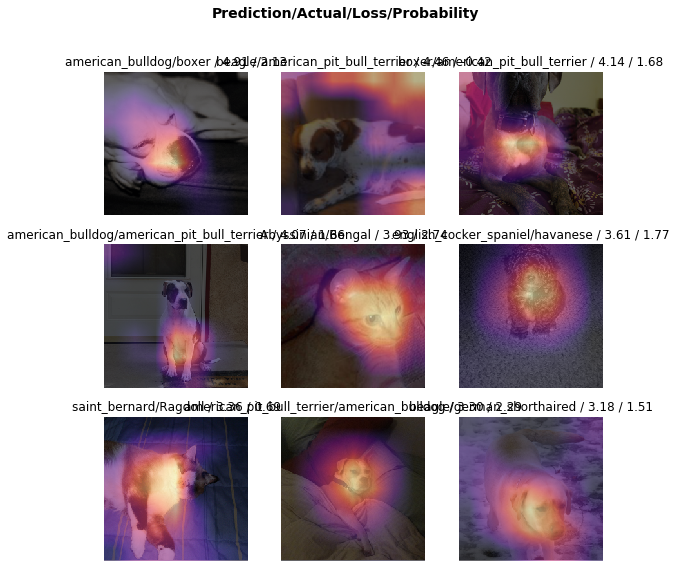

In [0]:
interpretation.plot_top_losses(9, figsize=(9,9), heatmap=True)

จะเห็นได้ว่ายากจริง ๆ เนื่องจากหมาและแมวบางพันธุ์ก็หน้าตารูปร่างใกล้เคียงกัน

*จากรูป plot_top_losses มีการแสดง [heat map](https://www.bualabs.com/archives/2008/visualization-inside-neural-network-analyze-activation-gradient-heatmap-gradcam-convnet-ep-4/) สีแดง ให้ดูด้วยว่า model พิจารณาเน้นจากส่วนไหนของรูปเป็นหลัก เรียกว่า Attention ที่ไว้เราจะอธิบายต่อไป*

สั่ง plot_confusion_matrix จะแสดงตาราง [Confusion Matrix](https://www.bualabs.com/archives/1968/what-is-metrics-confusion-matrix-accuracy-precision-recall-f1-score-difference-metrics-ep-1/) ตัดกันของหมวดหมู่ทั้งหมด 37 x 37 ว่าข้อมูลจริงคือพันธุ์อะไร (Row) แล้วโมเดลทายว่าพันธุ์อะไร (Column) สังเกตุที่ทายถูกจะเป็นเส้นแทยงมุมตรงกลาง

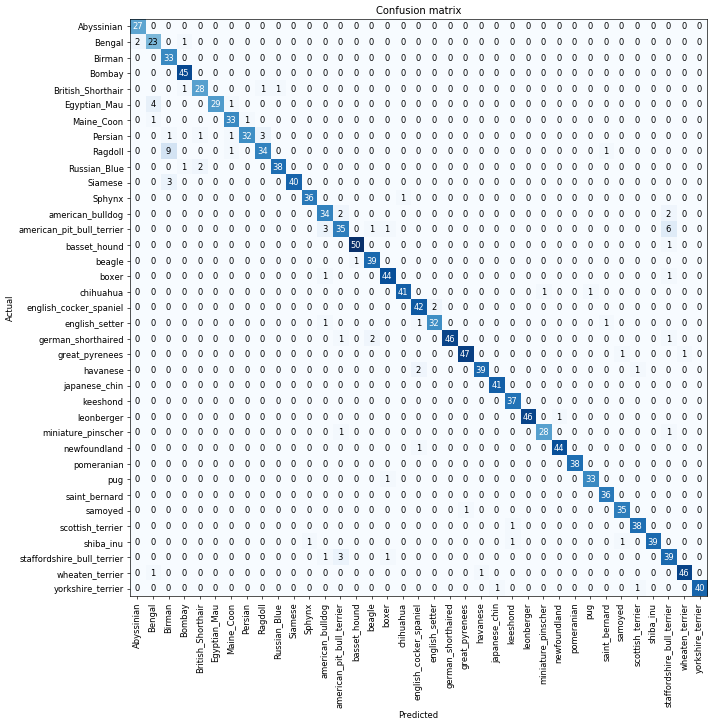

In [0]:
interpretation.plot_confusion_matrix(figsize=(12,12), dpi=60)

เนื่องจาก 37 พันธุ์ เรียกว่าค่อนข้างมาก ทำให้ตารางมีขนาดใหญ่ ตัวหนังสือเลยมีขนาดเล็ก อ่านยาก แต่เราสามารถดูคราว ๆ ได้ว่าส่วนใหญ่ทายถูก มี 1 และ 2 อยู่กระจาย ๆ ไป

เรียกดู most_confused คือ พันธุ์ที่โมเดลทายผิดมากที่สุดเรียงลงไป

In [0]:
interpretation.most_confused(min_val=2)

[('Ragdoll', 'Birman', 9),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 6),
 ('Egyptian_Mau', 'Bengal', 4),
 ('Persian', 'Ragdoll', 3),
 ('Siamese', 'Birman', 3),
 ('american_pit_bull_terrier', 'american_bulldog', 3),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 3),
 ('Bengal', 'Abyssinian', 2),
 ('Russian_Blue', 'British_Shorthair', 2),
 ('american_bulldog', 'american_pit_bull_terrier', 2),
 ('american_bulldog', 'staffordshire_bull_terrier', 2),
 ('english_cocker_spaniel', 'english_setter', 2),
 ('german_shorthaired', 'beagle', 2),
 ('havanese', 'english_cocker_spaniel', 2)]

เราสามารถเอาชื่อพันธุ์ไป Search Google Image ดูได้ ว่าทั้ง 2 พันธุ์หน้าตาคล้ายกันจริง ๆ

# 8. เทรนต่อ

เนื่องจากโดย Default แล้ว cnn_learner จะ Freeze Layer อื่น ๆ นอกจาก Layer สุดท้ายไว้ คือจะไม่มีการเทรนต่อ ที่เราเทรนตอนแรก คือ เทรนเฉพาะ Layer สุดท้ายที่สร้างใหม่เท่านั้น แต่ตอนนี้เรากำลังจะ Fine Tune หรือเทรนโดยละเอียดทั้งโมเดล เทรนทุก Layer

unfreeze layer ทุก Layer ให้สามารถเทรนได้

In [0]:
learner.unfreeze()

[lr_find](https://www.bualabs.com/archives/2377/lr-find-best-learning-rate-train-machine-learning-model-deep-neural-network-callback-neural-network-ep-12/) ฟังก์ชันนี้ จะลองเทรนโมเดลดู โดยค่อย ๆ เพิ่ม Learning Rate ไปจนกระทั้ง Loss พุ่ง เพื่อดูว่าโมเดลสามารถรับ Learning Rate ได้มากสุดเท่าไร

In [0]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


พล็อตกราฟ Learning Rate มาดู จะเห็นได้ว่า Loss ค่อย ๆ เพิ่มตาม Learning Rate ค่อย ๆ ชันไปจนพุ่งทะลุเพดาน ที่ประมาณ 1e-3

Min numerical gradient: 9.12E-07
Min loss divided by 10: 1.10E-07


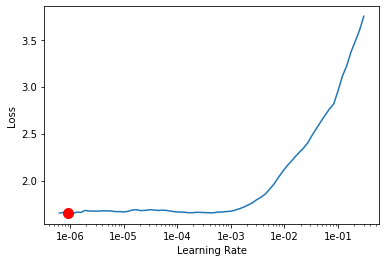

In [0]:
learner.recorder.plot(suggestion=True)

ให้เราเลือก Learning Rate ก่อนที่มันจะชันแล้วลดลง 2-5 เท่า แล้วลองเทรนดู ถ้าผลลัพธ์ไม่น่าพอใจก็ให้ load โมเดลใหม่ แล้วปรับ Learning Rate 

fit_one_cycle เทรนแบบ Cycle

* 12 epoch
* max_lr คือ เนื่องจากเรากำลังเทรนหลาย ๆ Layer พร้อม ๆ กัน แล้ว Layer แต่ละ Layer ก็ต้องการ Learning Rate ที่ไม่เท่ากัน เราสามารถกำหนด Learning Rate ให้กับทุก ๆ Layer ได้ด้วยฟังก์ชัน slice ที่จะกระจายให้ทุก Layer ไล่ค่าตั้งแต่ Layer แรก = 1e-6 น้อยสุด ไป Layer สุดท้าย = 5e-4 มากสุด

In [0]:
learner.fit_one_cycle(12, max_lr=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,1.654172,0.902059,0.941137,00:55
1,1.650833,0.896569,0.942490,00:55
2,1.641168,0.894866,0.941137,00:55
3,1.611863,0.892379,0.940460,00:55
4,1.602559,0.886447,0.939784,00:55
5,1.592845,0.884869,0.942490,00:55
6,1.576980,0.883806,0.947226,00:56
7,1.561521,0.881165,0.945873,00:55
8,1.576559,0.879064,0.945873,00:56
9,1.553334,0.882709,0.943843,00:55


## สำเร็จแล้ว 2 ##

เพียงเวลาแค่อีก 12 นาทีเศษ เราเทรน Model ได้ accuracy ประมาณ 0.95 หรือ ความแม่นยำประมาณ 95.0%

เปรียบเทียบกับเทรนครั้งแรก 94% ที่เทรนเฉพาะ Layer สุดท้าย 

เซฟโมเดลเก็บไว้ก่อน

In [0]:
learner.save('01h-image-classification-pets-resnet34-2')

In [0]:
learner.load('01h-image-classification-pets-resnet34-2');

# 10. สรุป



1. เราได้เรียนรู้การเทรนโมเดล [Neural Network](https://www.bualabs.com/archives/1763/what-is-neural-network-how-neural-network-work-build-deep-neural-network-from-scratch-neural-network-ep-1/) แบบ [Deep Learning](https://www.bualabs.com/archives/tag/deep-learning/) ที่ได้ผลลัพธ์แม่นยำ 95% โดยใช้เวลาเทรนเพียงแค่ไม่เกิน 20 นาที ด้วย Mixup กับ Label Smoothing 
1. Mixup อาจจะต้องการการเทรนที่นานกว่าการเทรนปกติ

# Credit 

* https://course.fast.ai/videos/?lesson=12
* https://www.bualabs.com/archives/469/how-to-deep-learning-pets-cats-dogs-image-classification-with-fastai-v1-ep-1/
* [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) by [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf)
* https://docs.fast.ai/callbacks.mixup.html
* https://forums.fast.ai/t/mixup-data-augmentation/22764
* https://arxiv.org/abs/1710.09412
* https://arxiv.org/abs/1906.02629
* https://course.fast.ai/videos/?lesson=12